In [24]:
# ===============================
# Convolutional Neural Network using Tensorflow using fit API
# Dataset: MNIST (Handwritten Digit Recognition)
# ===============================
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from functools import partial
import optuna

Loading MNIST dataset...
(70000, 784) (70000,)
Data loaded:
X_train shape: (48999, 784, 1), y_train shape: (48999,)
Preprocessing data...
X_train shape: (48999, 28, 28, 1), y_train shape: (48999, 1)


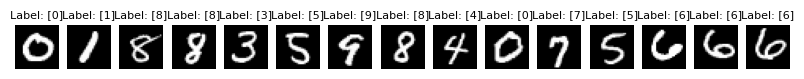

In [38]:
# =======================================
# 1. Load and Preprocess Data
# =======================================
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]
print(X.shape, y.shape) # (70000, 784) (70000,)

def train_val_test_split(
    X: np.ndarray,
    y: np.ndarray,
    train_size: float =0.7,
    val_size: float =0.15,
    test_size: float =0.15,
    random_state: int =42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split data into train, validation, and test sets

    Parameters:
    X : np.ndarray
        Feature data
    y : np.ndarray
        Labels
    train_size : float
        Proportion of data for training set
    val_size : float
        Proportion of data for validation set
    test_size : float
        Proportion of data for test set
    random_state : int
        Random seed for reproducibility

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test : np.ndarrays
        Split datasets
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sizes must sum to 1"
    # First split: train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=random_state, stratify=y)
    # Compute proportion of validation relative to temp
    val_prop = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_prop), random_state=random_state, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Usage:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

# Grayscale images (1 channel)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Data loaded:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Reshape (grayscale 28x28)
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize
print("Preprocessing data...")
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train).reshape(-1, 1)
y_val = encoder.transform(y_val).reshape(-1, 1)
y_test = encoder.transform(y_test).reshape(-1, 1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
output_dim = int(len(np.unique(y_train)))

def plot_images(X, y, y_true=None, num_images=15):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i].squeeze(), cmap="gray")
        title = f"Label: {y[i]}"
        color = "black"
        if y_true is not None:
            title += f"\nTrue: {y_true[i]}"
            if y[i] == y_true[i]:
                color = "green"
            else:
                color = "red"
        plt.title(title, color=color, fontsize=8)
        plt.axis("off")
    plt.show()

plot_images(X_train, y_train)

In [39]:
# =======================================
# RNG setup 
RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

In [40]:
# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 64,
    shuffle: bool = True
) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset for image data (CNN-ready)

    Parameters
    ----------
    X : np.ndarray
        Image array of shape (N, H, W, C)
    y : np.ndarray
        Label array (one-hot or integer)
    batch_size : int
        Batch size for the dataset (default=64)
    shuffle : bool
        Whether to shuffle the dataset (default=True)

    Returns
    -------
    tf.data.Dataset
        Optimized TensorFlow dataset ready for training
    """
    # Convert to tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
    # Dataset from tuple (X, y)
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    # Shuffle if required
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=RNG_SEED)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [41]:
# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": lambda: tf.keras.layers.ReLU(),
    "sigmoid": lambda: tf.keras.layers.Activation("sigmoid"),
    "tanh": lambda: tf.keras.layers.Activation("tanh"),
    "leaky_relu": lambda: tf.keras.layers.LeakyReLU(negative_slope=0.01),
    "gelu": lambda: tf.keras.layers.Activation(tf.nn.gelu),
    "elu": lambda: tf.keras.layers.ELU(),
    "softmax_logit": None  # handled separately for logits
}

In [ ]:
# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    conv_layers: List[Tuple[int, int]] = None
    dense_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = True

In [ ]:
# =======================================
# 5. Model Definition — CNN Version (2D & 3D)
# =======================================
class ConvNN(tf.keras.Model):
    def __init__(
        self,
        conv_layers: List[Tuple[int, int]], 
        dense_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True,
        use_pooling: bool = True
    ):
        """
        Configurable CNN supporting both grayscale (H,W,1) and RGB (H,W,3)

        Parameters:
        conv_layers : List[Tuple[int, int]]
            Each tuple defines (filters, kernel_size)
        dense_layers : List[int]
            Sizes of fully connected layers
        output_dim : int
            Number of output classes
        activations : List[str], optional
            Activation functions for dense layers
        dropout_rates : List[float], optional
            Dropout rates for dense layers
        use_batchnorm : bool
            Whether to apply batch normalization
        use_pooling : bool
            Whether to apply MaxPooling after convolutions
        """
        super().__init__()
        self.layers_list = []

        # Convolutional feature extractor
        for idx, (filters, ksize) in enumerate(conv_layers):
            self.layers_list.append(tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=ksize,
                padding="same",
                activation=None,
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer="zeros",
            ))
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            self.layers_list.append(tf.keras.layers.ReLU())
            if use_pooling:
                self.layers_list.append(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Flatten before dense layers
        self.layers_list.append(tf.keras.layers.Flatten())

        # Fully connected classifier
        n_dense = len(dense_layers)
        if activations is None:
            activations = ["relu"] * n_dense
        if dropout_rates is None:
            dropout_rates = [0.0] * n_dense
        assert len(activations) == n_dense
        assert len(dropout_rates) == n_dense

        for idx, units in enumerate(dense_layers):
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            kernel_init = (tf.keras.initializers.HeNormal() if act_name in ("relu", "leaky_relu") else tf.keras.initializers.GlorotNormal())
            self.layers_list.append(tf.keras.layers.Dense(units, kernel_initializer=kernel_init, bias_initializer="zeros"))
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            if act_ctor is not None:
                self.layers_list.append(act_ctor() if callable(act_ctor) else act_ctor)
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                self.layers_list.append(tf.keras.layers.Dropout(dropout_rates[idx]))

        # Output layer (no activation to logits)
        self.layers_list.append(tf.keras.layers.Dense(output_dim, kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer="zeros"))

    def call(
        self: tf.keras.Model,
        inputs: tf.Tensor,
        training: bool = False
    ) -> tf.Tensor:
        """
        Forward pass through the network

        Parameters:
        inputs : tf.Tensor
            Input tensor
        training : bool, optional
            Whether in training mode (for dropout, batchnorm)

        Returns:
        tf.Tensor
            Output logits tensor
        """
        x = inputs
        for layer in self.layers_list:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

In [44]:
# =======================================
# 6. Training Function
# =======================================
def train_model(
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_val: np.ndarray,
    y_val: np.ndarray,
    output_dim: int,
    config: TrainConfig,
    plot_loss: bool = False
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    """
    Train the Convolutional Neural Network model

    Parameters:
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    output_dim : int
        Number of output classes
    config : TrainConfig
        Training configuration parameters
    plot_loss : bool, optional
        Whether to plot training and validation loss curves

    Returns:
    model : tf.keras.Model
        Trained model
    history : tf.keras.callbacks.History
        Training history object
    """
    # Dataloaders
    train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=config.batch_size, shuffle=True)
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size, shuffle=False)

    # AMP policy
    if config.use_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Model creation
    model = ConvNN(
            conv_layers=config.conv_layers,
            dense_layers=config.dense_layers, 
            output_dim=output_dim,
            activations=config.activations, 
            dropout_rates=config.dropout_rates, 
            use_batchnorm=True, 
            use_pooling=True
        )

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.lr,
        decay_steps=config.step_size * len(train_dataset),
        decay_rate=config.gamma,
        staircase=True,
    )

    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=config.weight_decay)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Callbacks (Early stopping + checkpoint)
    callbacks = []
    if config.early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=config.patience,
                restore_best_weights=True, verbose=1,
            )
        )

    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model_cnn.weights.h5",
            monitor="val_loss",
            save_best_only=True, save_weights_only=True,
        )
    )

    # Train the model
    history = model.fit(
        train_dataset, validation_data=val_dataset,
        epochs=config.epochs,
        verbose=1,callbacks=callbacks,
    )

    # Plot losses
    if plot_loss:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Val Loss")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model, history

In [56]:
# =======================================
# 7. Prediction & Evaluation
# =======================================
def predict_tf(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray, 
    batch_size: int = 64
) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Predict classes and probabilities using the trained model

    Parameters:
    model : tf.keras.Model
        Trained model
    X : np.ndarray
        Input features
    y : np.ndarray
        True labels
    batch_size : int, optional
        Batch size for prediction  

    Returns:
    np.ndarray
        Predicted class labels
    np.ndarray
        Predicted class probabilities
    """
    ds = df_to_tf_dataset(X, y, batch_size=batch_size, shuffle=False) 
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds.reshape(-1, 1), probs.numpy()

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels

    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100

In [46]:
# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(
    trial: optuna.trial.Trial,
    loss_function: str = "cross_entropy",
    epochs: int = 40
) -> float:
    """
    Objective function for Optuna hyperparameter optimization

    Parameters:
    trial : optuna.trial.Trial
        Optuna trial object
    loss_function : str, optional
        Loss function to use
    epochs : int, optional
        Number of training epochs
    Returns:
    float
        Validation loss to minimize
    """
    # Number of convolutional layers
    n_conv_layers = trial.suggest_int("n_conv_layers", 2, 4)
    conv_layers = []
    for i in range(n_conv_layers):
        filters = trial.suggest_int(f"conv_filters_l{i}", 32, 128, step=32)
        kernel_size = trial.suggest_categorical(f"conv_kernel_size_l{i}", [3, 5])
        conv_layers.append((filters, kernel_size))

    # Number of dense layers
    n_dense_layers = trial.suggest_int("n_dense_layers", 1,2)
    dense_layers = []
    for i in range(n_dense_layers):
        dense_layers.append(trial.suggest_int(f"n_units_l{i}", 128, 512))
        
    # Common activation (keeps optimization stable)
    # activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])
    # activations = [activation] * n_dense_layers
    # possible_activations = ["relu", "tanh", "leaky_relu"]
    # activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_dense_layers)]

    # Regularization
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.1, 0.4) for i in range(n_dense_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Optimizer params
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    step_size = trial.suggest_float("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.7, 0.99, log=True)

    # Early stopping
    stopping_patience = trial.suggest_int("stopping_patience", 5, 15)

    config = TrainConfig(
        conv_layers=conv_layers, 
        dense_layers=dense_layers,
        activations=None, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=True
    )

    model, _ = train_model(
        X_train, 
        y_train, 
        X_val,
        y_val,
        output_dim,
        config,
        plot_loss=False
    )

    # Validation loss
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    val_loss_metric = tf.keras.metrics.Mean()
    for X_batch, y_batch in val_dataset:
        logits = model(X_batch, training=False)
        val_loss_metric.update_state(loss_fn(y_batch, logits))

    return val_loss_metric.result().numpy()

# Run Optuna study
loss_function = "cross_entropy"
epochs = 20
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=1)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-01 21:29:22,743] A new study created in memory with name: no-name-12e0971a-b4c4-4e4e-9a48-10e00f5d1dc0


Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 0.6458 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.0746 - val_sparse_categorical_accuracy: 0.9775
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9751 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9832
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0542 - val_sparse_categorical_accuracy: 0.9830
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0433 - val_sparse_categorical_accuracy: 0.9868
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9857
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0263 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0516 - val_sparse_categoric

2025-11-01 21:39:36.095756: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 21:39:36,108] Trial 0 finished with value: 0.03714895248413086 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 64, 'conv_kernel_size_l1': 5, 'conv_filters_l2': 96, 'conv_kernel_size_l2': 3, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 3, 'n_dense_layers': 2, 'n_units_l0': 230, 'n_units_l1': 324, 'dropout_l0': 0.19226926178322623, 'dropout_l1': 0.29182106179705003, 'weight_decay': 8.929625896670494e-06, 'lr': 0.0001624502775701837, 'batch_size': 32, 'step_size': 12.231226213835807, 'gamma': 0.969753239825687, 'stopping_patience': 15}. Best is trial 0 with value: 0.03714895248413086.


Best trial:
  Value: 0.0371
  Params:
    n_conv_layers: 4
    conv_filters_l0: 32
    conv_kernel_size_l0: 5
    conv_filters_l1: 64
    conv_kernel_size_l1: 5
    conv_filters_l2: 96
    conv_kernel_size_l2: 3
    conv_filters_l3: 128
    conv_kernel_size_l3: 3
    n_dense_layers: 2
    n_units_l0: 230
    n_units_l1: 324
    dropout_l0: 0.19226926178322623
    dropout_l1: 0.29182106179705003
    weight_decay: 8.929625896670494e-06
    lr: 0.0001624502775701837
    batch_size: 32
    step_size: 12.231226213835807
    gamma: 0.969753239825687
    stopping_patience: 15


Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - loss: 0.6463 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.0933 - val_sparse_categorical_accuracy: 0.9732
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0940 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.0538 - val_sparse_categorical_accuracy: 0.9837
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0825 - val_sparse_categorical_accuracy: 0.9731
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.0433 - val_sparse_categorical_accuracy: 0.9867
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9879
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 0.0270 - sparse_categorical_accuracy: 0.9917 - val_loss: 0.0371 - val_sparse_categoric

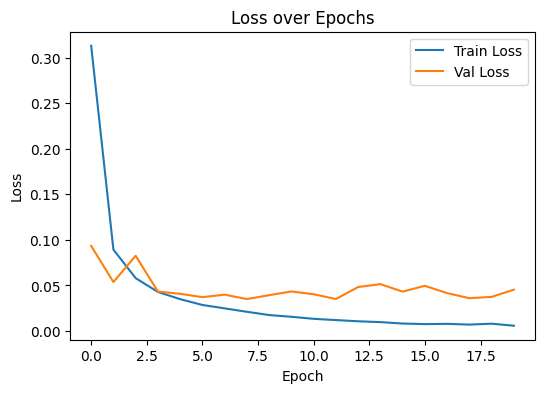

2025-11-01 21:49:52.938323: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Accuracy: 10.03%


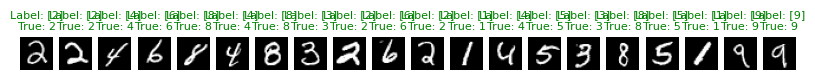

In [ ]:
# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_conv_layers = best_params["n_conv_layers"]
conv_layers = []
for i in range(n_conv_layers):
    filters = best_params[f"conv_filters_l{i}"]
    kernel_size = best_params[f"conv_kernel_size_l{i}"]
    conv_layers.append((filters, kernel_size))
n_dense_layers = best_params["n_dense_layers"]
dense_layers = [best_params[f"n_units_l{i}"] for i in range(n_dense_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_dense_layers)]
weight_decay = best_params["weight_decay"]
stopping_patience = best_params["stopping_patience"]
# activations = [best_params[f"activation_l{i}"] for i in range(n_dense_layers)]
# activations = [best_params["activation"]] * n_dense_layers
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    conv_layers=conv_layers, 
    dense_layers=dense_layers,
    activations=None, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs, 
    weight_decay=weight_decay, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model, history = train_model(
    X_train, 
    y_train,
    X_test, 
    y_test,
    output_dim,
    config,
    plot_loss=True
)

Test Accuracy: 99.01%


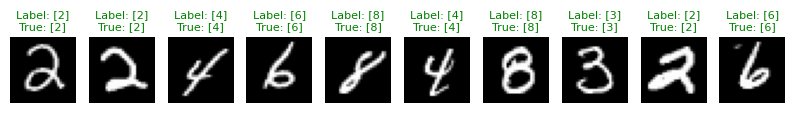

In [58]:
# Evaluate on test set
y_pred_test, p = predict_tf(best_model, X_test, y_test, batch_size=batch_size)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=10)